In [4]:
# Standard imports
import pandas as pd
import numpy as np

# Local module imports
import sys
import os
sys.path.append(os.path.abspath('../'))

from src.preprocessing.cleaning import handle_missing_values, remove_duplicates, convert_to_datetime
from src.preprocessing.feature_engineering import extract_time_features, convert_ip_to_int, merge_ip_country
from src.preprocessing.transform import encode_categorical, scale_features, handle_imbalance
from src.preprocessing.utils import load_csv, save_csv


In [11]:
# Load raw data
fraud_df = pd.read_csv('../data/raw/Fraud_Data.csv', parse_dates=['purchase_time', 'signup_time'])
ip_map_df = load_csv('../data/raw/IpAddress_to_Country.csv')


In [ ]:
# Exploring the data set

print(fraud_df.head())
fraud_df.info()
fraud_df.describe()
print(fraud_df.isnull().sum())
fraud_df.dtypes


   user_id         signup_time       purchase_time  purchase_value  \
0    22058 2015-02-24 22:55:49 2015-04-18 02:47:11              34   
1   333320 2015-06-07 20:39:50 2015-06-08 01:38:54              16   
2     1359 2015-01-01 18:52:44 2015-01-01 18:52:45              15   
3   150084 2015-04-28 21:13:25 2015-05-04 13:54:50              44   
4   221365 2015-07-21 07:09:52 2015-09-09 18:40:53              39   

       device_id source browser sex  age    ip_address  class  
0  QVPSPJUOCKZAR    SEO  Chrome   M   39  7.327584e+08      0  
1  EOGFQPIZPYXFZ    Ads  Chrome   F   53  3.503114e+08      0  
2  YSSKYOSJHPPLJ    SEO   Opera   M   53  2.621474e+09      1  
3  ATGTXKYKUDUQN    SEO  Safari   M   41  3.840542e+09      0  
4  NAUITBZFJKHWW    Ads  Safari   M   45  4.155831e+08      0  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151112 entries, 0 to 151111
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          ----------

user_id                    int64
signup_time       datetime64[ns]
purchase_time     datetime64[ns]
purchase_value             int64
device_id                 object
source                    object
browser                   object
sex                       object
age                        int64
ip_address               float64
class                      int64
dtype: object

In [ ]:
# display the class distribution
print(fraud_df['class'].value_counts())

class
0    136961
1     14151
Name: count, dtype: int64


In [12]:
# Handle missing values
fraud_df = handle_missing_values(fraud_df, strategy="drop")

# Remove duplicates
fraud_df = remove_duplicates(fraud_df)

In [13]:
# Time-based features
fraud_df = extract_time_features(fraud_df, 'purchase_time', 'signup_time')

# IP to integer
fraud_df = convert_ip_to_int(fraud_df)

# Convert IP bounds to integers in ip_map_df
ip_map_df['lower_bound_ip_address'] = ip_map_df['lower_bound_ip_address'].apply(int)
ip_map_df['upper_bound_ip_address'] = ip_map_df['upper_bound_ip_address'].apply(int)

# Merge geolocation
fraud_df = merge_ip_country(fraud_df, ip_map_df)

# Check new features
fraud_df[['hour_of_day', 'day_of_week', 'time_since_signup', 'country']].head()


,hour_of_day,day_of_week,time_since_signup,country
0,2,Saturday,1251.856111,Japan
1,1,Monday,4.984444,United States
2,18,Thursday,0.000278,United States
3,13,Monday,136.690278,Unknown
4,18,Wednesday,1211.516944,United States


In [16]:
# Encoding categorical features
categorical_cols = ['source', 'browser', 'sex', 'country', 'day_of_week', 'hour_of_day']
fraud_df_encoded, encoder = encode_categorical(fraud_df, categorical_cols)

# Preview
fraud_df_encoded.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,age,ip_address,class,time_since_signup,ip_int,...,hour_of_day_14,hour_of_day_15,hour_of_day_16,hour_of_day_17,hour_of_day_18,hour_of_day_19,hour_of_day_20,hour_of_day_21,hour_of_day_22,hour_of_day_23
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,39,7.327584e+08,0,1251.856111,732758368,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,53,3.503114e+08,0,4.984444,350311387,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,53,2.621474e+09,1,0.000278,2621473820,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,41,3.840542e+09,0,136.690278,3840542443,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,45,4.155831e+08,0,1211.516944,415583117,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [1]:
import pandas as pd
fraud_df_encoded=pd.read_csv('../data/processed/fraud_df_encoded.csv')

In [2]:
Xf = fraud_df_encoded.drop(columns=['class', 'user_id', 'device_id', 'ip_address', 'signup_time', 'purchase_time'])
yf = fraud_df_encoded['class']

In [3]:
from sklearn.model_selection import train_test_split



Xf_train, Xf_test, yf_train, yf_test = train_test_split(
    Xf, yf, test_size=0.2, stratify=yf, random_state=42
)


In [ ]:
# Scaling features
from sklearn.preprocessing import StandardScaler, MinMaxScaler

def scale_fr_features(X_train, X_test, method="standard"):
    if method == "standard":
        scaler = StandardScaler()
    elif method == "minmax":
        scaler = MinMaxScaler()
    else:
        raise ValueError("Invalid method. Choose 'standard' or 'minmax'.")

    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    return X_train_scaled, X_test_scaled, scaler

In [ ]:
# Apply scaling
Xf_train_scaled, Xf_test_scaled, scaler = scale_fr_features(Xf_train, Xf_test, method="standard")

In [ ]:
# Handle Class Imbalance (SMOTE)

Xf_train_bal, yf_train_bal = handle_imbalance(Xf_train_scaled, yf_train)

# Check new class distribution
pd.Series(yf_train_bal).value_counts()


class
0    109568
1    109568
Name: count, dtype: int64

In [ ]:
# Load the processed data using joblib

import joblib

Xf_train_scaled = joblib.load('../data/processed/Xf_train_scaled.pkl')
Xf_test_scaled = joblib.load('../data/processed/Xf_test_scaled.pkl')
yf_train_bal = joblib.load('../data/processed/yf_train_bal.pkl')
yf_test = joblib.load('../data/processed/yf_test.pkl')

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, average_precision_score
import pandas as pd
import numpy as np

# Define models to try
models = {
    "Logistic Regression": LogisticRegression(random_state=42, max_iter=1000),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "XGBoost": XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'),
}

# Store results
results = []
confusion_matrices = {}

for name, model in models.items():
    print(f"\nTraining {name}...")
    
    # Train model on balanced data
    model.fit(Xf_train_bal, yf_train_bal)
    
    # Predict on the un-balanced test set
    y_pred = model.predict(Xf_test_scaled)
    
    # Get probabilities for metrics
    y_proba = model.predict_proba(Xf_test_scaled)[:, 1] if hasattr(model, "predict_proba") else None
    
    # Evaluate
    acc = accuracy_score(yf_test, y_pred)
    prec = precision_score(yf_test, y_pred, zero_division=0)
    rec = recall_score(yf_test, y_pred)
    f1 = f1_score(yf_test, y_pred)
    
    # Use AUC-PR for imbalanced data, in addition to AUC-ROC
    auc_roc = roc_auc_score(yf_test, y_proba) if y_proba is not None else "N/A"
    auc_pr = average_precision_score(yf_test, y_proba) if y_proba is not None else "N/A"
    
    # Store confusion matrix for later analysis
    cm = confusion_matrix(yf_test, y_pred)
    confusion_matrices[name] = cm
    
    results.append({
        "Model": name,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1 Score": f1,
        "AUC-ROC": auc_roc,
        "AUC-PR": auc_pr
    })

# Convert to DataFrame
results_df = pd.DataFrame(results).sort_values(by="AUC-PR", ascending=False)
print("\n📊 Model Comparison:\n")
print(results_df.reset_index(drop=True))

print("\n--- Confusion Matrices ---")
for name, cm in confusion_matrices.items():
    print(f"\n{name} Confusion Matrix:")
    print(cm)
    # Explain the matrix
    tn, fp, fn, tp = cm.ravel()
    print(f"  True Negatives (Correctly identified non-fraud): {tn}")
    print(f"  False Positives (Incorrectly flagged as fraud): {fp}")
    print(f"  False Negatives (Missed fraud cases): {fn}")
    print(f"  True Positives (Correctly identified fraud): {tp}")


Training Logistic Regression...

Training Random Forest...

Training Gradient Boosting...

Training XGBoost...


c:\Users\mike\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:24:54] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



📊 Model Comparison:

                 Model  Accuracy  Precision    Recall  F1 Score   AUC-ROC  \
0    Gradient Boosting  0.955531   0.995995  0.527208  0.689464  0.772154   
1        Random Forest  0.954273   0.969520  0.528269  0.683898  0.761790   
2              XGBoost  0.952619   0.937422  0.529329  0.676603  0.766562   
3  Logistic Regression  0.662608   0.172490  0.685512  0.275627  0.745776   

     AUC-PR  
0  0.623516  
1  0.613311  
2  0.600725  
3  0.403735  

--- Confusion Matrices ---

Logistic Regression Confusion Matrix:
[[18086  9307]
 [  890  1940]]
  True Negatives (Correctly identified non-fraud): 18086
  False Positives (Incorrectly flagged as fraud): 9307
  False Negatives (Missed fraud cases): 890
  True Positives (Correctly identified fraud): 1940

Random Forest Confusion Matrix:
[[27346    47]
 [ 1335  1495]]
  True Negatives (Correctly identified non-fraud): 27346
  False Positives (Incorrectly flagged as fraud): 47
  False Negatives (Missed fraud cases): 13

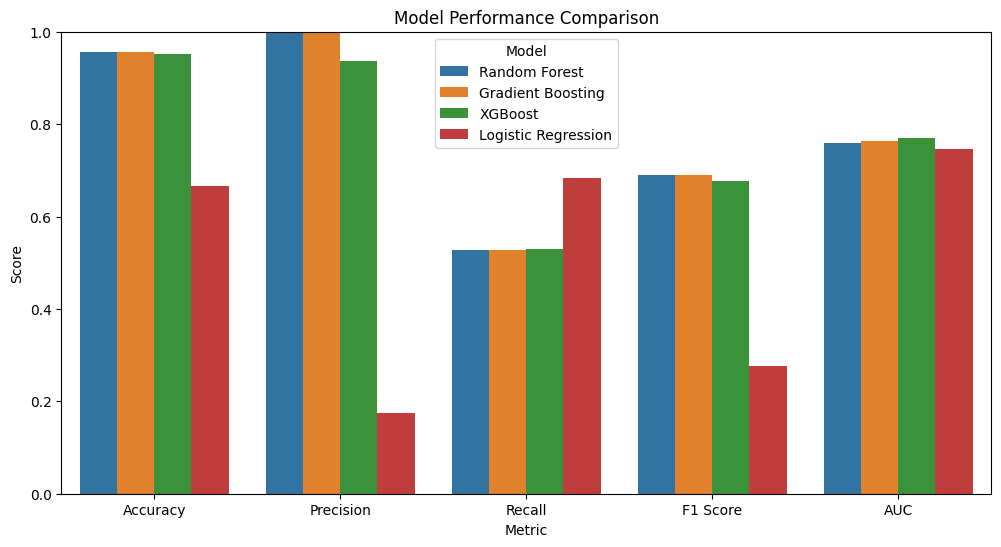

In [ ]:
# Visualize model performance comparison
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming results_df is your model comparison DataFrame
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC-ROC', 'AUC-PR']
results_melted = results_df.melt(id_vars='Model', value_vars=metrics, var_name='Metric', value_name='Score')

plt.figure(figsize=(12, 6))
sns.barplot(data=results_melted, x='Metric', y='Score', hue='Model')
plt.title('Model Performance Comparison')
plt.ylim(0, 1)
plt.show()


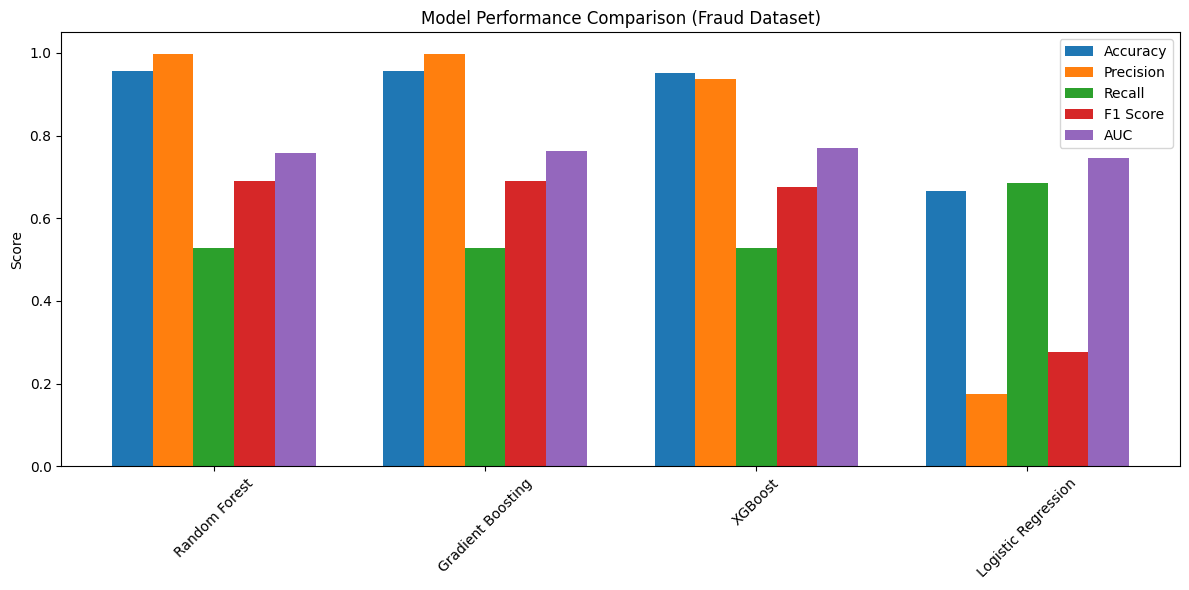

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd


# Plot grouped bar chart
metrics = ["Accuracy", "Precision", "Recall", "F1 Score", "AUC-ROC", "AUC-PR"]
x = range(len(results_df["Model"]))
bar_width = 0.15

plt.figure(figsize=(12, 6))

for i, metric in enumerate(metrics):
    plt.bar(
        [p + bar_width*i for p in x],
        results_df[metric],
        width=bar_width,
        label=metric
    )

plt.xticks([p + bar_width*2 for p in x], results_df["Model"], rotation=45)
plt.ylabel("Score")
plt.ylim(0, 1.05)
plt.title("Model Performance Comparison (Fraud Dataset)")
plt.legend()
plt.tight_layout()
plt.show()


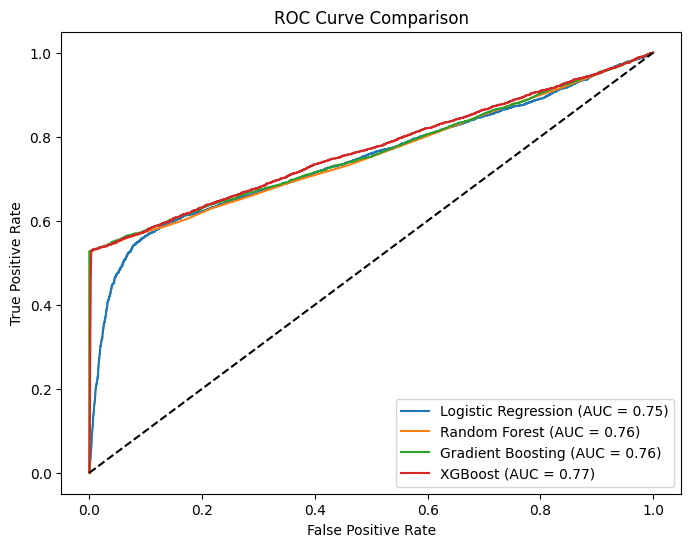

In [ ]:
# Plot ROC Curves for each model
from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(8,6))

for name, model in models.items():
    y_proba = model.predict_proba(Xf_test_scaled)[:, 1]
    fpr, tpr, _ = roc_curve(yf_test, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

plt.plot([0,1], [0,1], 'k--')
plt.title('ROC Curve Comparison')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()


In [7]:
Xf_test_scaled_df = pd.DataFrame(Xf_test_scaled, columns=Xf.columns)

In [ ]:
# Identify all columns to drop before applying SHAP

columns_to_drop = ['class', 'user_id', 'device_id', 'ip_address', 'signup_time', 'purchase_time']

# Identify the categorical columns that were one-hot encoded
categorical_features = ['source', 'browser', 'sex', 'country', 'day_of_week', 'hour_of_day'] # Assuming 'country' was created in your merging step

# Create a list of the numerical columns that you will keep
all_columns = fraud_df.columns.tolist()
numerical_features = [col for col in all_columns if col not in columns_to_drop and col not in categorical_features]

# Perform One-Hot Encoding and get the new feature names
from sklearn.preprocessing import OneHotEncoder

# Get the names of the new columns created by the encoder.
encoded_feature_names = list(encoder.get_feature_names_out(categorical_features))

# Combine the lists to create the final list of feature names
all_feature_names_after_preprocessing = numerical_features + encoded_feature_names

Using the best model for SHAP analysis: Gradient Boosting
SHAP will be computed on a stratified sample of size: 1000

Generating SHAP Summary Plot...


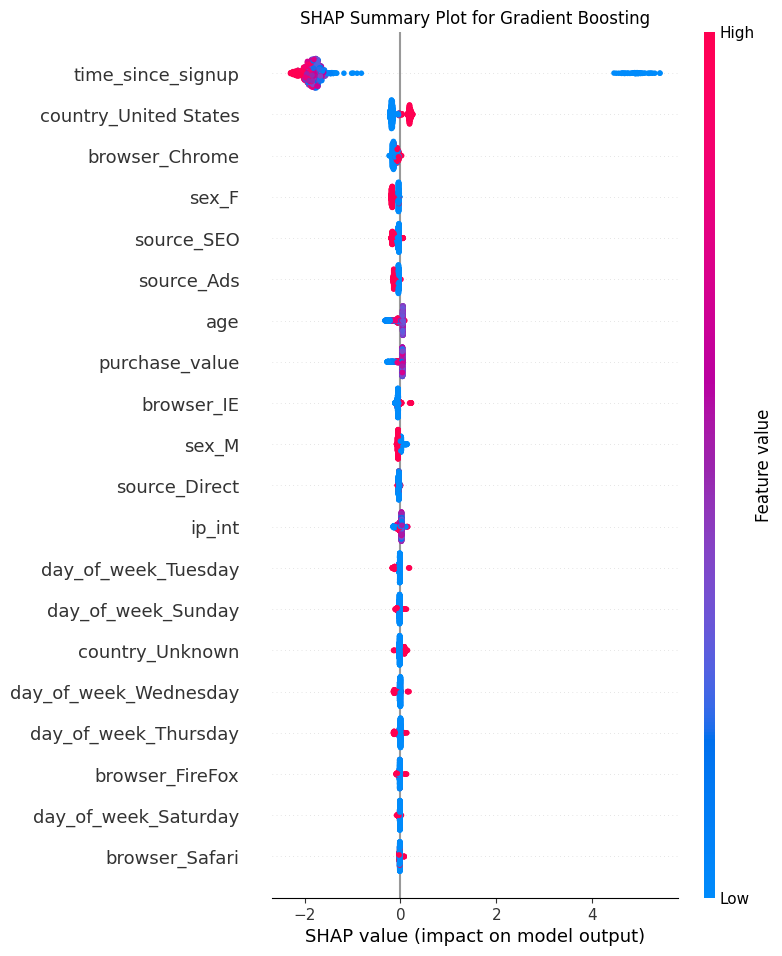

c:\Users\mike\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(



Generating SHAP Force Plot for a True Positive (Fraudulent) transaction...


In [19]:
import shap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Make sure you have this list ready from your preprocessing steps
# all_feature_names_after_preprocessing = ['purchase_value', 'age', 'time_since_signup', 'source_SEO', 'source_Ads', ...]

# --- 1. Identify the best model ---
best_model_name = results_df.sort_values(by="AUC-PR", ascending=False).iloc[0]["Model"]
best_model = models[best_model_name]
print(f"Using the best model for SHAP analysis: {best_model_name}")

# --- 2. Create a Representative Sample for SHAP ---
sample_size = 1000
if len(Xf_test_scaled) > sample_size:
    from sklearn.model_selection import StratifiedShuffleSplit
    
    # Create DataFrame with the correct column names
    X_test_scaled_df = pd.DataFrame(Xf_test_scaled, columns=all_feature_names_after_preprocessing)

    sss = StratifiedShuffleSplit(n_splits=1, test_size=sample_size, random_state=42)
    for _, test_index in sss.split(X_test_scaled_df, yf_test):
        X_test_sample = X_test_scaled_df.iloc[test_index]
        y_test_sample = yf_test.iloc[test_index]
else:
    X_test_sample = pd.DataFrame(Xf_test_scaled, columns=all_feature_names_after_preprocessing)
    y_test_sample = yf_test

print(f"SHAP will be computed on a stratified sample of size: {len(X_test_sample)}")

# --- 3. Calculate SHAP Values ---
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test_sample)

# --- 4. Generate and Interpret SHAP Plots ---
print("\nGenerating SHAP Summary Plot...")
shap.summary_plot(shap_values, X_test_sample, show=False)
plt.title(f'SHAP Summary Plot for {best_model_name}')
plt.show()

# Find an example of a True Positive (correctly predicted as fraudulent)
tp_index = np.where((best_model.predict(X_test_sample) == 1) & (y_test_sample == 1))[0]
if len(tp_index) > 0:
    tp_instance_index = tp_index[0]
    print("\nGenerating SHAP Force Plot for a True Positive (Fraudulent) transaction...")
    shap.initjs()
    display(shap.force_plot(explainer.expected_value, shap_values[tp_instance_index,:], X_test_sample.iloc[tp_instance_index,:]))
else:
    print("\nCould not find a True Positive example in the sample.")